# California Housing Price Prediction

download dataset from here [https://www.kaggle.com/camnugent/california-housing-prices](https://www.kaggle.com/camnugent/california-housing-prices)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!dir | findstr -i housing.csv

03-08-2019  11:48         1,444,170 housing.csv


In [4]:
housing = pd.read_csv("housing.csv")
housing.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


there are 20640 instances & 'total_bedrooms' has only 20433 non-null values (207 values missing)

In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


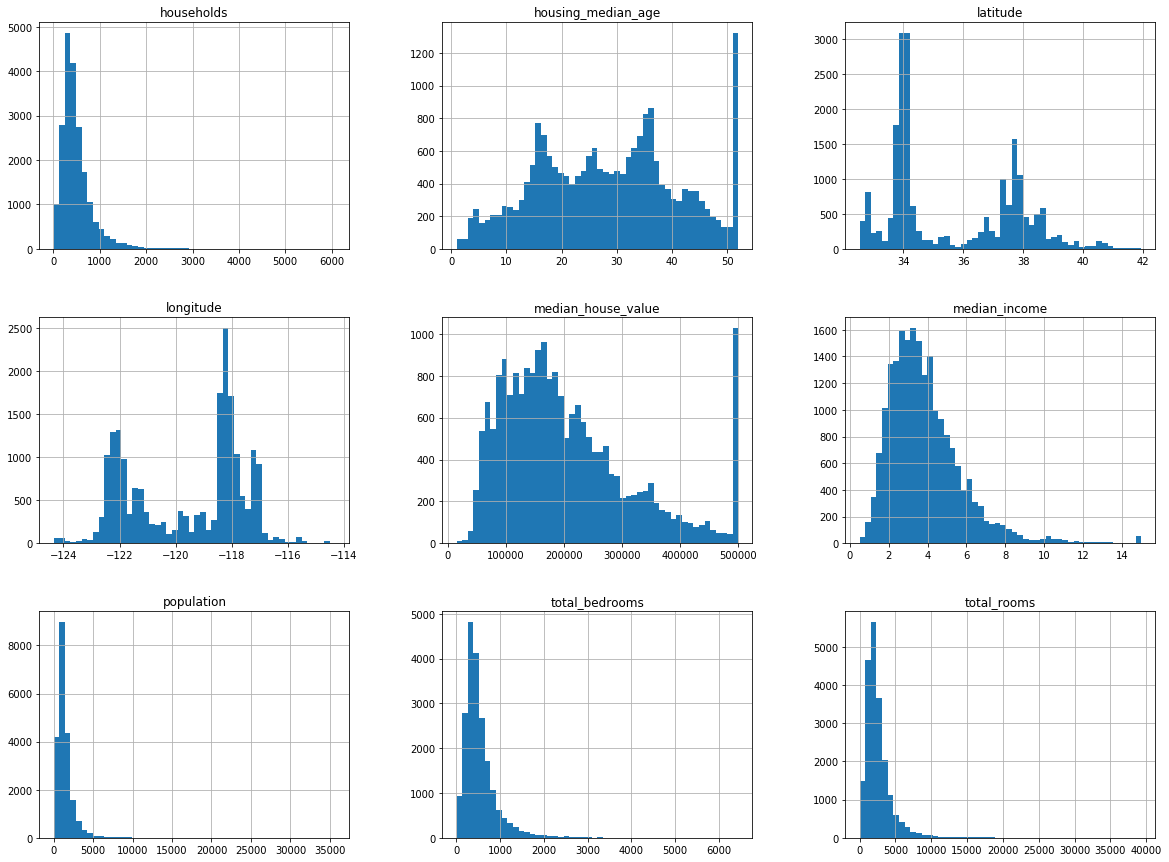

In [9]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

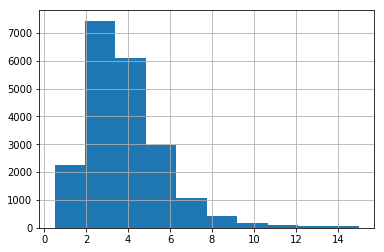

In [10]:
# median income looks like an imp feature

housing['median_income'].hist()

In [11]:
# dividing the income category to limit the number income category
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
# putting everything above 5th category as 5th category
housing['income_cat'].where(housing['income_cat'] < 5, other=5.0, inplace=True)

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=29)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [16]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [17]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

**as seen above the proportions are maintained in the test set using stratified sampling**

**[why stratified?]** : because the feature-space are less and also because its a mid-sized dataset & we don't want to miss out any class


In [18]:
# experimenting: with random sampling now

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=29)

In [22]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts() / len(data)


comparing_props = pd.DataFrame({
    "Overall Props": income_cat_proportions(housing),
    "Random": income_cat_proportions(test_set),
    "Stratified": income_cat_proportions(strat_test_set)
}).sort_index()

comparing_props["random %error"] = 100 * comparing_props["Random"] / comparing_props["Overall Props"] - 100
comparing_props["strat. %error"] = 100 * comparing_props["Stratified"] / comparing_props["Overall Props"] - 100
comparing_props

,Overall Props,Random,Stratified,random %error,strat. %error
1.0,0.039826,0.042636,0.039729,7.055961,-0.243309
2.0,0.318847,0.311531,0.318798,-2.294484,-0.015195
3.0,0.350581,0.344719,0.350533,-1.672195,-0.013820
4.0,0.176308,0.181686,0.176357,3.050289,0.027480
5.0,0.114438,0.119428,0.114583,4.360711,0.127011


In [23]:
for items in (strat_train_set, strat_test_set):
    items.drop("income_cat", axis=1, inplace=True)

In [24]:
housing = strat_train_set.copy()

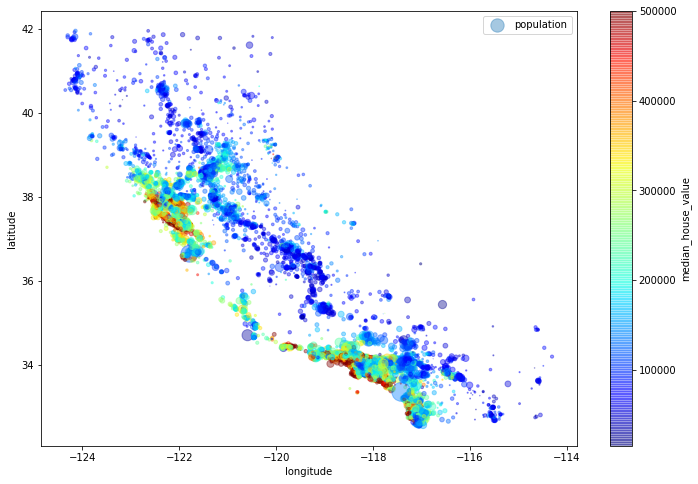

In [27]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing['population']/100, label="population", figsize=(12,8),
            c="median_house_value", cmap=plt.get_cmap("jet"), sharex=False)

plt.legend()

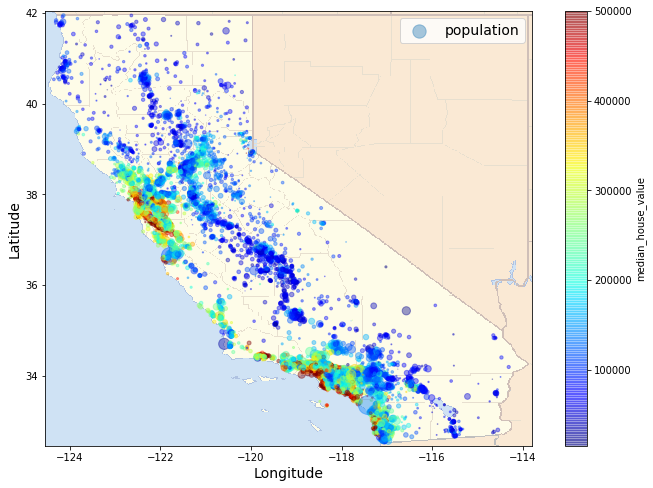

In [32]:
import matplotlib.image as mpimg

ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing['population']/100, label="population", figsize=(12,8),
            c="median_house_value", cmap=plt.get_cmap("jet"), sharex=False)

# load the png image
california_img = mpimg.imread("california.png")

plt.imshow(california_img, extent=[-124.55, -113.8, 32.45, 42.05], alpha=0.5, cmap=plt.get_cmap("jet"))

plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

plt.legend(fontsize=14)
plt.show()

### Looking for Correlations
(Pearson's Distance Correlation equation)

In [34]:
# pandas has corr method for calculating correlations
corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.691071
total_rooms           0.127306
housing_median_age    0.108483
households            0.060084
total_bedrooms        0.043921
population           -0.028341
longitude            -0.043780
latitude             -0.146422
Name: median_house_value, dtype: float64

its always between -1 (less correlated) and 1 (highly correlated)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023201601828>,
      dtype=object)

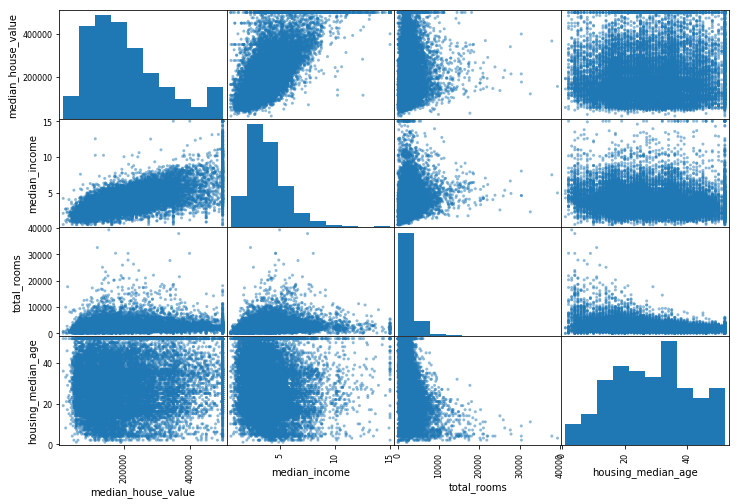

In [36]:
# other approach it to use the scatter plot in a A vs B fashion
# problem with this is that (for N features, there will be N^2 plots)

imp_attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

from pandas.plotting import scatter_matrix

scatter_matrix(housing[imp_attributes], figsize=(12, 8))

[0, 16, 0, 550000]

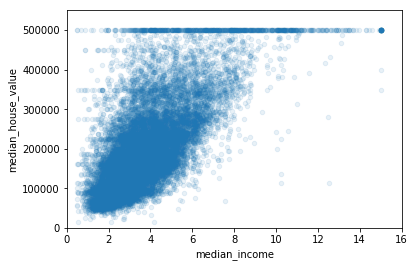

In [39]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.axis([0, 16, 0, 550000])

### Feature Engineering



In [40]:
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]

In [41]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.691071
rooms_per_household         0.151804
total_rooms                 0.127306
housing_median_age          0.108483
households                  0.060084
total_bedrooms              0.043921
population_per_household   -0.021688
population                 -0.028341
longitude                  -0.043780
latitude                   -0.146422
bedrooms_per_room          -0.253572
Name: median_house_value, dtype: float64

**[observation]:** the new `bedrooms_per_room` is highly correlated but in a reciprocative way to the `median_house_value`, So the houses with lesser bedroom/room ratio will tend to be more expensive.

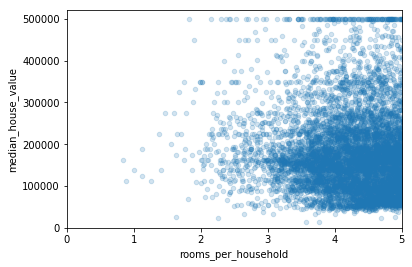

In [43]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value", alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [44]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,bedrooms_per_room,population_per_household,rooms_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16349.000000,16512.000000,16512.000000,16512.000000,16512.000000,16349.000000,16512.000000,16512.000000
mean,-119.574691,35.642798,28.655220,2622.124879,535.192672,1418.447372,496.865492,3.870355,206418.759872,0.212973,3.103875,5.434516
std,2.005064,2.142773,12.535491,2171.310387,421.124910,1137.484934,382.194550,1.903633,115088.961605,0.058323,11.603193,2.520743
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.100000,0.692308,0.846154
25%,-121.800000,33.930000,18.000000,1446.000000,295.000000,785.000000,279.000000,2.559725,119175.000000,0.175448,2.433980,4.443478
50%,-118.500000,34.260000,29.000000,2123.000000,433.000000,1159.000000,407.000000,3.532750,179650.000000,0.202964,2.817596,5.230221
75%,-118.010000,37.720000,37.000000,3121.250000,641.000000,1715.000000,599.000000,4.739375,264700.000000,0.239351,3.273248,6.056361
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,1.000000,1243.333333,141.909091


# Preparing the data for ML algos

In [45]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### some data cleansing

In [48]:
# when calculating imputng value on your own
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()

median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
5654,-118.30,33.73,42.0,1731.0,433.0,866.0,403.0,2.7451,NEAR OCEAN
14930,-117.02,32.66,19.0,771.0,433.0,376.0,108.0,6.6272,NEAR OCEAN
9814,-121.93,36.62,34.0,2351.0,433.0,1063.0,428.0,3.7250,NEAR OCEAN
14986,-117.03,32.73,34.0,2061.0,433.0,1169.0,400.0,3.5096,NEAR OCEAN
4767,-118.37,34.03,37.0,1236.0,433.0,966.0,292.0,3.0694,<1H OCEAN


In [49]:
# when using Scikit-Learn's Imputer class
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [50]:
housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [51]:
# Imputer basically computes across all the attributes, so if you wanna see this across all the attributes, just call statistics_ method
imputer.statistics_

array([-118.5    ,   34.26   ,   29.     , 2123.     ,  433.     ,
       1159.     ,  407.     ,    3.53275])

In [52]:
housing_num.median().values

array([-118.5    ,   34.26   ,   29.     , 2123.     ,  433.     ,
       1159.     ,  407.     ,    3.53275])

using the imputer we created above, transforming the training set by replacing the missing values by the learned medians

In [53]:
X = imputer.transform(housing_num)

In [54]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [56]:
# cross check for missing value
housing_tr[housing_tr.isnull().any(axis=1)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income


In [57]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-118.09,33.92,35.0,1994.0,419.0,1491.0,428.0,3.7383
1,-122.57,37.96,52.0,3458.0,468.0,1449.0,471.0,9.1834
2,-121.96,36.97,23.0,4324.0,1034.0,1844.0,875.0,3.0777
3,-118.28,34.02,52.0,281.0,103.0,470.0,96.0,1.9375
4,-116.50,33.81,26.0,5032.0,1229.0,3086.0,1183.0,2.5399


#### handling categorical values

In [60]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

7771      <1H OCEAN
9352       NEAR BAY
18657    NEAR OCEAN
4873      <1H OCEAN
12350        INLAND
18621    NEAR OCEAN
15543     <1H OCEAN
14129    NEAR OCEAN
18136     <1H OCEAN
14418    NEAR OCEAN
Name: ocean_proximity, dtype: object

In [61]:
# using pandas's own factorize() method to convert them into categorical features
housing_cat_encoded, housing_categories = housing_cat.factorize()

In [62]:
housing_cat_encoded[:10]

array([0, 1, 2, 0, 3, 2, 0, 2, 0, 2], dtype=int64)

In [63]:
housing_categories

Index(['<1H OCEAN', 'NEAR BAY', 'NEAR OCEAN', 'INLAND', 'ISLAND'], dtype='object')

In [66]:
# using Scikit-Learn's OneHotEncoder

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(1, -1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [67]:
housing_cat_1hot

<1x16512 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [68]:
# since 1 hot encoder returns a sparse matrix, need to change it to a dense array
housing_cat_1hot.toarray()

array([[1., 1., 1., ..., 1., 1., 1.]])

### Custom Transformations

In [69]:
from sklearn.base import BaseEstimator, TransformerMixin

#column indexes
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self # nothing to do here
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [70]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [71]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", 
                                                                                           "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-118.09,33.92,35,1994,419,1491,428,3.7383,<1H OCEAN,4.65888,3.48364
1,-122.57,37.96,52,3458,468,1449,471,9.1834,NEAR BAY,7.34183,3.07643
2,-121.96,36.97,23,4324,1034,1844,875,3.0777,NEAR OCEAN,4.94171,2.10743
3,-118.28,34.02,52,281,103,470,96,1.9375,<1H OCEAN,2.92708,4.89583
4,-116.5,33.81,26,5032,1229,3086,1183,2.5399,INLAND,4.25359,2.60862


## Setting up Pipeline for all the preprocessings

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[ 0.74049299, -0.80402818,  0.50616062, ..., -0.30771122,
         0.03273077, -0.05512278],
       [-1.49391785,  1.081436  ,  1.86235125, ...,  0.75666902,
        -0.0023651 , -1.17763788],
       [-1.18967887,  0.61940394, -0.45115041, ..., -0.19550447,
        -0.08587951,  0.38012387],
       ...,
       [-1.18967887,  0.79208259,  0.58593654, ..., -0.06328319,
        -0.06658929, -0.48812906],
       [-0.09741107,  0.51673015,  1.22414389, ..., -0.43053438,
         0.07888273,  0.19240118],
       [ 0.17690276, -0.64535051, -1.00958184, ..., -0.32344572,
        -0.05235215,  0.40450624]])

In [77]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attibute_names = attribute_names
        
    def fit(self, X, y=None):
        return self # do nothing
    
    def transform(self, X, y=None):
        return X[self.attibute_names].values

In [78]:
# complete Pipeline

num_attribs = list(housing_num.columns)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ("selector", DataFrameSelector(num_attribs)),
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler())
])

cat_pipeline =Pipeline([
    ("selector", DataFrameSelector(cat_attribs)),
    ("cat_encoder", OneHotEncoder(sparse=False))
])

In [79]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [80]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[ 0.74049299, -0.80402818,  0.50616062, ...,  0.        ,
         0.        ,  0.        ],
       [-1.49391785,  1.081436  ,  1.86235125, ...,  0.        ,
         1.        ,  0.        ],
       [-1.18967887,  0.61940394, -0.45115041, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-1.18967887,  0.79208259,  0.58593654, ...,  0.        ,
         0.        ,  0.        ],
       [-0.09741107,  0.51673015,  1.22414389, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.17690276, -0.64535051, -1.00958184, ...,  0.        ,
         0.        ,  1.        ]])

## Selecting & Training Models

In [82]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [83]:
# trying the full pipeline on a few training instances

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)

In [84]:
print("Prediction: ", lin_reg.predict(some_data_prepared))
print("Actual Labels: ", list(some_labels))

Prediction:  [209526.30110297 455497.76141409 252936.22210586 173615.33127943
 114294.56522481]
Actual Labels:  [166200.0, 500001.0, 263800.0, 38800.0, 94800.0]


In [85]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)

lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67949.91466225038

In [86]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [87]:
housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

#### Cross Validation:

In [89]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, cv=10, scoring="neg_mean_squared_error")

tree_rmse_scores = np.sqrt(-scores)

In [91]:
def display_scores(scores):
    print("scores: ", scores)
    print("mean: ", scores.mean())
    print("std deviation: ", scores.std())
    
    
display_scores(tree_rmse_scores)

scores:  [69593.69145862 70066.170738   68646.05018041 72166.87630862
 69847.77786532 67682.2018582  68697.31100345 71457.02304872
 67330.53128353 69350.50615695]
mean:  69483.81399018272
std deviation:  1442.1060415883137


In [92]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, cv=10, scoring="neg_mean_squared_error")

lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

scores:  [67641.22210761 69245.155892   65690.83401976 67581.651926
 66586.04760743 66937.30771561 67397.33645629 69807.64170261
 66660.63451034 74883.89423608]
mean:  68243.17261737355
std deviation:  2500.726216291981


In [93]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=29)
forest_reg.fit(housing_prepared, housing_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=29, verbose=0, warm_start=False)

In [94]:
housing_pred = forest_reg.predict(housing_prepared)

forest_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, cv=10, scoring="neg_mean_squared_error")

forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

scores:  [67641.22210761 69245.155892   65690.83401976 67581.651926
 66586.04760743 66937.30771561 67397.33645629 69807.64170261
 66660.63451034 74883.89423608]
mean:  68243.17261737355
std deviation:  2500.726216291981


## Fine Tuning Model: 

In [95]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

rf_reg = RandomForestRegressor()

grid_search = GridSearchCV(rf_reg, param_grid, cv=5, scoring="neg_mean_squared_error")

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [96]:
# to get the best combination of hyperparameters
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [97]:
# to get the best estimators directly
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [98]:
cv_res = grid_search.cv_results_

for mean_score, params in zip(cv_res["mean_test_score"], cv_res["params"]):
    print(np.sqrt(-mean_score), params)

61948.817870375125 {'max_features': 2, 'n_estimators': 3}
54847.743699686565 {'max_features': 2, 'n_estimators': 10}
52210.65425187522 {'max_features': 2, 'n_estimators': 30}
60262.1047265938 {'max_features': 4, 'n_estimators': 3}
52078.921457323886 {'max_features': 4, 'n_estimators': 10}
49731.20841157175 {'max_features': 4, 'n_estimators': 30}
57327.2779448621 {'max_features': 6, 'n_estimators': 3}
51075.36836587005 {'max_features': 6, 'n_estimators': 10}
49316.32731959365 {'max_features': 6, 'n_estimators': 30}
58108.1161993501 {'max_features': 8, 'n_estimators': 3}
51182.66472132552 {'max_features': 8, 'n_estimators': 10}
49395.15431784256 {'max_features': 8, 'n_estimators': 30}
60694.6221756083 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53615.157026913854 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59855.94989626242 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
51685.94308571316 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

In [99]:
pd.DataFrame(grid_search.cv_results_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.082066,0.010623,0.003989,8.120244e-07,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.917675e+09,-3.918486e+09,...,-3.837656e+09,1.066955e+08,18,-1.104529e+09,-1.138527e+09,-1.009285e+09,-1.053214e+09,-9.398896e+08,-1.049089e+09,7.014076e+07
1,0.249546,0.012824,0.012161,1.714277e-03,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.014728e+09,-2.939942e+09,...,-3.008275e+09,6.064130e+07,11,-5.409988e+08,-5.561183e+08,-5.639566e+08,-5.765585e+08,-5.487376e+08,-5.572740e+08,1.229337e+07
2,0.757691,0.012564,0.033901,1.990957e-03,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.748083e+09,-2.615862e+09,...,-2.725952e+09,7.432624e+07,9,-4.246204e+08,-4.248330e+08,-4.343068e+08,-4.329200e+08,-4.072039e+08,-4.247768e+08,9.653673e+06
3,0.119889,0.001716,0.004196,1.591592e-03,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.547854e+09,-3.390399e+09,...,-3.631521e+09,1.696415e+08,16,-8.755087e+08,-9.469164e+08,-9.553304e+08,-1.022442e+09,-9.080572e+08,-9.416509e+08,4.948806e+07
4,0.401524,0.054749,0.010086,2.080228e-04,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.663668e+09,-2.650057e+09,...,-2.712214e+09,5.862387e+07,8,-5.057418e+08,-5.062400e+08,-5.086964e+08,-5.170541e+08,-4.867039e+08,-5.048872e+08,9.957279e+06
5,1.164760,0.026036,0.034661,4.673423e-03,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.432028e+09,-2.387239e+09,...,-2.473193e+09,7.269600e+07,3,-3.701220e+08,-3.891925e+08,-3.819714e+08,-3.794607e+08,-3.802003e+08,-3.801894e+08,6.101055e+06
6,0.182510,0.017606,0.004789,1.466213e-03,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.266734e+09,-3.138541e+09,...,-3.286417e+09,1.908289e+08,12,-8.240381e+08,-9.215263e+08,-8.677857e+08,-8.750200e+08,-8.265270e+08,-8.629794e+08,3.589156e+07
7,0.545978,0.006374,0.013766,3.534279e-03,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.660269e+09,-2.512321e+09,...,-2.608693e+09,9.435699e+07,5,-4.859186e+08,-4.863053e+08,-4.774111e+08,-4.890069e+08,-4.771453e+08,-4.831575e+08,4.917626e+06
8,1.621598,0.021463,0.034906,2.819119e-03,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.384931e+09,-2.389579e+09,...,-2.432100e+09,7.111086e+07,1,-3.811493e+08,-3.714742e+08,-3.696982e+08,-3.795588e+08,-3.649787e+08,-3.733718e+08,6.104234e+06
9,0.205751,0.006878,0.004382,1.017714e-03,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.062998e+09,-3.454207e+09,...,-3.376553e+09,1.780084e+08,14,-8.400859e+08,-9.122632e+08,-8.855219e+08,-9.101869e+08,-8.173229e+08,-8.730762e+08,3.811695e+07


In [102]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

params_distibs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8),
}

rf_reg = RandomForestRegressor(random_state=29)

rnd_search = RandomizedSearchCV(rf_reg, param_distributions=params_distibs, n_iter=10, 
                                cv=5, scoring="neg_mean_squared_error", random_state=29)

rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=29, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000232047497B8>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023204749B38>},
          pre_dispatch='2*n_jobs', random_state=29, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [103]:
cvres = rnd_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

48554.82808753229 {'max_features': 6, 'n_estimators': 116}
49443.37797311243 {'max_features': 5, 'n_estimators': 35}
53570.23831992085 {'max_features': 1, 'n_estimators': 97}
50902.01282842812 {'max_features': 2, 'n_estimators': 114}
53580.16560373702 {'max_features': 1, 'n_estimators': 98}
48632.80337452587 {'max_features': 7, 'n_estimators': 95}
53454.896572172365 {'max_features': 1, 'n_estimators': 156}
48524.00649818885 {'max_features': 6, 'n_estimators': 149}
48560.27239481039 {'max_features': 7, 'n_estimators': 152}
53446.573293355774 {'max_features': 1, 'n_estimators': 165}


In [104]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.41334595e-02, 6.93251261e-02, 4.28858803e-02, 1.67398629e-02,
       1.53967567e-02, 1.67265216e-02, 1.56845873e-02, 3.50336080e-01,
       5.33067138e-02, 1.03676537e-01, 6.89793469e-02, 1.41822793e-02,
       1.51038146e-01, 1.74301679e-04, 2.92257502e-03, 4.49182635e-03])

In [105]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.35033607970584973, 'median_income'),
 (0.15103814554651854, 'INLAND'),
 (0.10367653743896124, 'pop_per_hhold'),
 (0.0741334595012775, 'longitude'),
 (0.06932512605594604, 'latitude'),
 (0.06897934691571558, 'bedrooms_per_room'),
 (0.05330671376736584, 'rooms_per_hhold'),
 (0.04288588027958395, 'housing_median_age'),
 (0.01673986289498515, 'total_rooms'),
 (0.016726521557328962, 'population'),
 (0.01568458732811972, 'households'),
 (0.01539675669445148, 'total_bedrooms'),
 (0.014182279262666901, '<1H OCEAN'),
 (0.004491826350088617, 'NEAR OCEAN'),
 (0.002922575021677729, 'NEAR BAY'),
 (0.00017430167946286612, 'ISLAND')]

In [106]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)